# ML notebook to predict what stops will be dropped from a route. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px

#NEW modules: please reinstall conda env!!
#we're gonna learn the living baby jesus out of this :)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, roc_auc_score, confusion_matrix

sys.path.append('../utils')
import helpers as h
import feature_engineering as f

In [3]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')

In [4]:
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))

C:\Users\tinne\AppData\Local\Temp\ipykernel_255512\291413550.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


In [5]:
# add route stop distances as feature
request_df = f.calculate_distances(request_df, 'stop_order')


100%|██████████| 18010/18010 [00:14<00:00, 1223.06it/s]


In [54]:
request_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop
610693,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71108,0.493993,0.315449,2022-06-09T07:30:00,2022-06-09T23:59:00,27,1,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.000000,0.000000,0.000949
610694,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71080,0.494289,0.314548,2022-06-09T07:30:00,2022-06-09T17:00:00,14,2,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.000949,0.000949,0.003482
610695,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71048,0.493936,0.311083,2022-06-09T07:30:00,2022-06-09T17:00:00,176,3,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.003482,0.004431,0.005125
610696,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71177,0.491165,0.315395,2022-06-09T00:00:00,2022-06-09T23:59:00,134,4,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.005125,0.009556,0.001414
610697,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71049,0.490411,0.316590,2022-06-09T07:30:00,2022-06-09T23:59:00,177,5,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.001414,0.010970,0.001499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766866,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65498,0.578363,0.098513,2022-06-17T07:30:00,2022-06-17T23:59:00,100,100,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000000,0.180777,0.000000
1766867,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65493,0.578363,0.098513,2022-06-17T07:30:00,2022-06-17T23:59:00,101,101,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000000,0.180777,0.000441
1766868,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65408,0.578175,0.098912,2022-06-17T07:30:00,2022-06-17T23:59:00,102,102,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000441,0.181218,0.000113
1766869,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65388,0.578287,0.098896,2022-06-17T07:30:00,2022-06-17T23:59:00,103,103,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000113,0.181331,0.000000


In [6]:
## add route centers as feature. 
request_df = f.get_route_center(request_df)

In [7]:
initial_dfs = []

for _, df in request_df.groupby('dir'):
    # Time is the timestamp coming from serverlog: compare first request with last non-PM request
    # REMEMBER THAT: PM requests were filtered out already.
    first_request_timestamp = df['Time'].min()
    last_request_timestamp = df['Time'].max()

    # Get the first and last request as dfs: 
    first_request_df = df.loc[df['Time'] == first_request_timestamp].copy()
    last_request_df = df.loc[df['Time'] == last_request_timestamp]

    # Only interested in dropped for generating MLs on dropping stops. 
    common, added, dropped = f.stop_diffs(first_request_df, last_request_df)

    # Add the column "gets_dropped" to first_request_df
    first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: int(x in dropped))

    initial_dfs.append(first_request_df)

In [8]:
initial_routes_df = pd.concat(initial_dfs)

In [9]:
# # extract weekday from route_date and add as column
initial_routes_df['route_date'] = pd.to_datetime(initial_routes_df['route_date'])
initial_routes_df['weekday'] = initial_routes_df['route_date'].dt.day_name()

# change weekday to numerical value
weekday_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
initial_routes_df['weekday'] = initial_routes_df['weekday'].map(weekday_mapping)

## ML Phase: 

In [10]:
models = {}

Feature engineering done; let's see what we're dealing with.

In [11]:
initial_routes_df.gets_dropped.mean()
#14.5% of initial route stops get dropped

0.1455619853493942

In [12]:
# Only keep needed columns into ml_df 
ml_df = initial_routes_df[['lat', 'long', 'stop_order','weekday' , 'dist_since_prev', 
                          'dist_cumulative', 'dist_to_next_stop', 'mean_lat',
                          'mean_long', 'dst_point_to_center', 'gets_dropped']]

In [13]:
#shuffle df: 
ml_df = ml_df.sample(frac=1).reset_index(drop=True)

In [14]:
#Train test split with a validation set! (strafied based on target (gets_dropped))
y_name = 'gets_dropped'
train_ratio = 70
test_ratio = 20
validation_ratio = 10
stratcols = [y_name]    #stratify on target only
train_df, test_df, validation_df = h.train_test_val_splitter(
                                ml_df, 
                                train_ratio,
                                test_ratio,
                                validation_ratio, 
                                stratcols
                            )

X_train, y_train = h.get_X_y(train_df, y_name)
X_test, y_test = h.get_X_y(test_df, y_name)
#DON'T TOUCH X_val and y_val now!!!!
X_val, y_val = h.get_X_y(validation_df, y_name)

In [15]:
# replace missing values in dist_to_next_stop with 0
X_test.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)

## Evaluate various classification models side by side

In [18]:
models={
    "Logisitic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "Adaboost":AdaBoostClassifier(),
    "Xgboost":XGBClassifier()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

c:\Users\tinne\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logisitic Regression
Model performance for Training set
- Accuracy: 0.8555
- F1 score: 0.7931
- Precision: 0.6135
- Recall: 0.0193
- Roc Auc Score: 0.5086
----------------------------------
Model performance for Test set
- Accuracy: 0.8558
- F1 score: 0.7942
- Precision: 0.6274
- Recall: 0.0228
- Roc Auc Score: 0.5103


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 0.9998
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.9159
- F1 score: 0.9162
- Precision: 0.7078
- Recall: 0.7189
- Roc Auc Score: 0.8342


Random Forest
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9996
- Roc Auc Score: 0.9998
----------------------------------
Model performance for Test set
- Accuracy: 0.9430
- F1 score: 0.9391
- Precision: 0.9182
- Recall: 0.6677
- Roc Auc Score: 0.8288


Gradient Boost
Model performance for Training se

In [ ]:
## Hyperparameter Training
rf_params = {"max_depth": [5, 10, 20],
             "max_features": ["auto"],
             "min_samples_split": [2, 5, 10],
             "n_estimators": [100, 200, 500]}
dt_params = {'criterion':['gini','entropy', 'log_loss'],
            'splitter':['best'],
            'max_depth':[10, 20, 30],
             'max_features':['auto','sqrt','log2']}
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 10, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.2, 0.4, 0.8, 1]}

In [ ]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("RF", RandomForestClassifier(), rf_params),
    ("DecisionTree", DecisionTreeClassifier(), dt_params),
    ("XGBoost", XGBClassifier(), xgboost_params)
    ]

In [22]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

c:\Users\tinne\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 96 candidates, totalling 288 fits
---------------- Best Params for XGBoost -------------------
{'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


## Random Search CV results
#### ---------------- Best Params for RF -------------------

{'n_estimators': 200, 'min_samples_split': 2, 'max_features': auto, 'max_depth': 20}

#### ---------------- Best Params for DecisionTree -------------------

{'splitter': 'best', 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}

#### ---------------- Best Params for Xgboost -------------------

{'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


XGBoost
Model performance for Training set
- Accuracy: 0.9999
- F1: 0.9999
- Precision: 0.9998
- Recall: 0.9993
- Roc_auc: 0.9996
----------------------------------
Model performance for Test set
- Accuracy: 0.9455
- F1: 0.9425
- Precision: 0.9060
- Recall: 0.6982
- Roc_auc: 0.8429



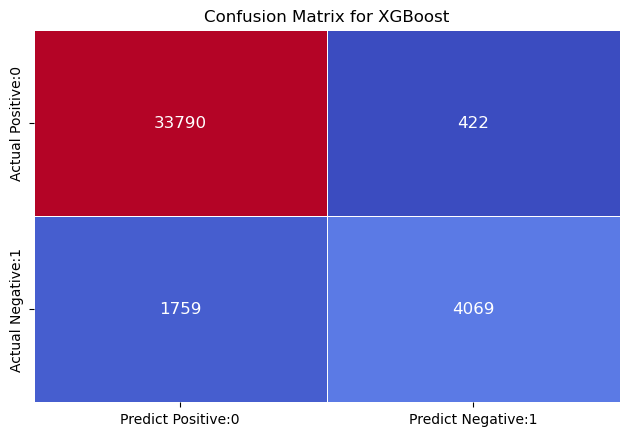

In [16]:
xgb_model = h.evaluate_model_performance(XGBClassifier(learning_rate= 0.1,
                  max_depth= 30,
                  n_estimators= 200,
                  colsample_bytree= 0.8), "XGBoost", X_train, y_train, X_val, y_val)


Decision Tree
Model performance for Training set
- Accuracy: 0.9639
- F1: 0.9624
- Precision: 0.9547
- Recall: 0.7892
- Roc_auc: 0.8914
----------------------------------
Model performance for Test set
- Accuracy: 0.9106
- F1: 0.9071
- Precision: 0.7320
- Recall: 0.6084
- Roc_auc: 0.7853



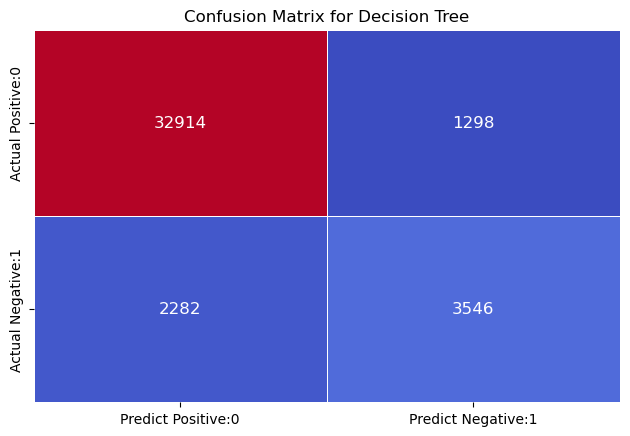

In [17]:
dt_model = h.evaluate_model_performance(DecisionTreeClassifier(
            criterion= 'entropy',
            splitter = 'best',
            max_depth = 20,
            max_features = 'log2'), 
            "Decision Tree", X_train, y_train, X_val, y_val)

c:\Users\tinne\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



Random Forest
Model performance for Training set
- Accuracy: 0.9683
- F1: 0.9667
- Precision: 0.9977
- Recall: 0.7842
- Roc_auc: 0.8920
----------------------------------
Model performance for Test set
- Accuracy: 0.9355
- F1: 0.9292
- Precision: 0.9408
- Recall: 0.5944
- Roc_auc: 0.7940



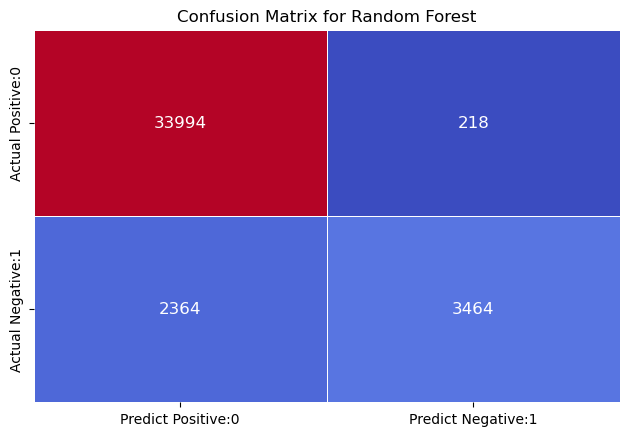

In [18]:
rf_model = h.evaluate_model_performance(RandomForestClassifier(
            max_depth= 20,
            max_features= 'auto',
            min_samples_split= 2,
            n_estimators= 200), 
            "Random Forest", X_train, y_train, X_val, y_val)

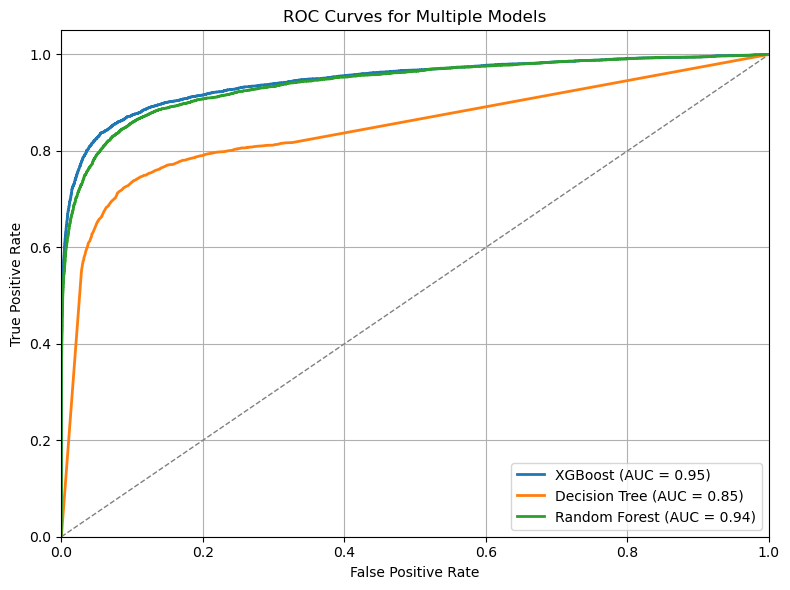

In [19]:
h.plot_roc_curves_from_results(xgb_model, dt_model, rf_model)

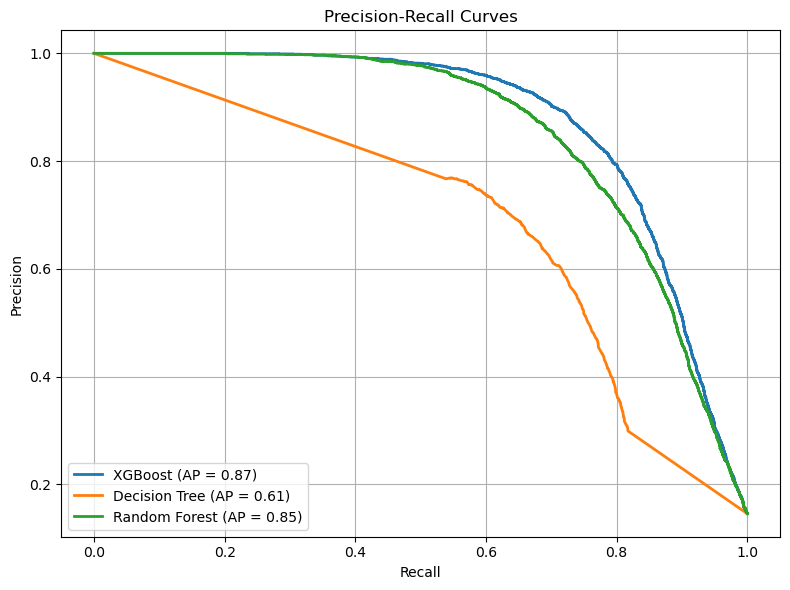

In [20]:
h.plot_precision_recall_curves(xgb_model, dt_model, rf_model)

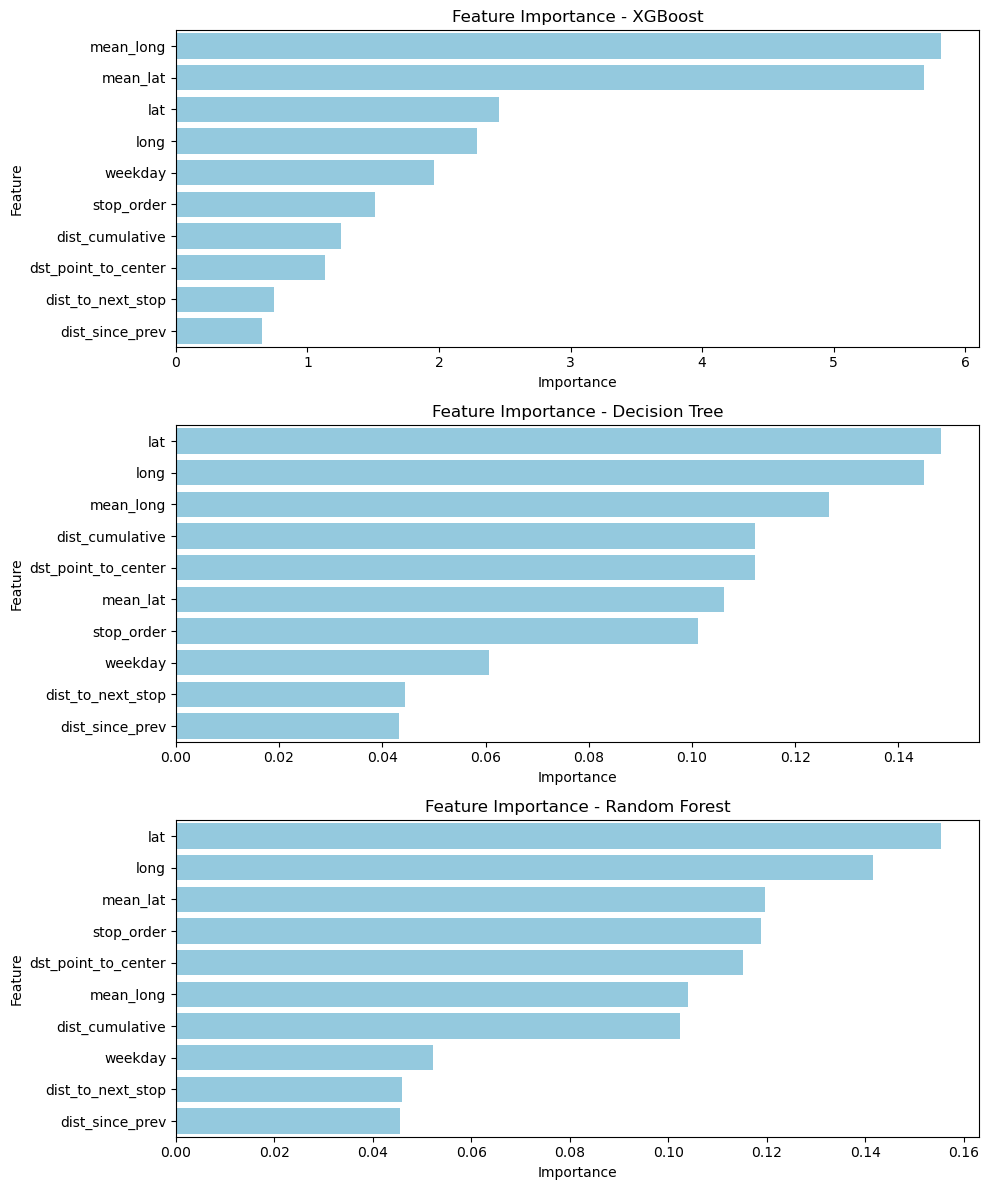

In [ ]:
h.plot_feature_importances_subplots(xgb_model, dt_model, rf_model, top_n=10)

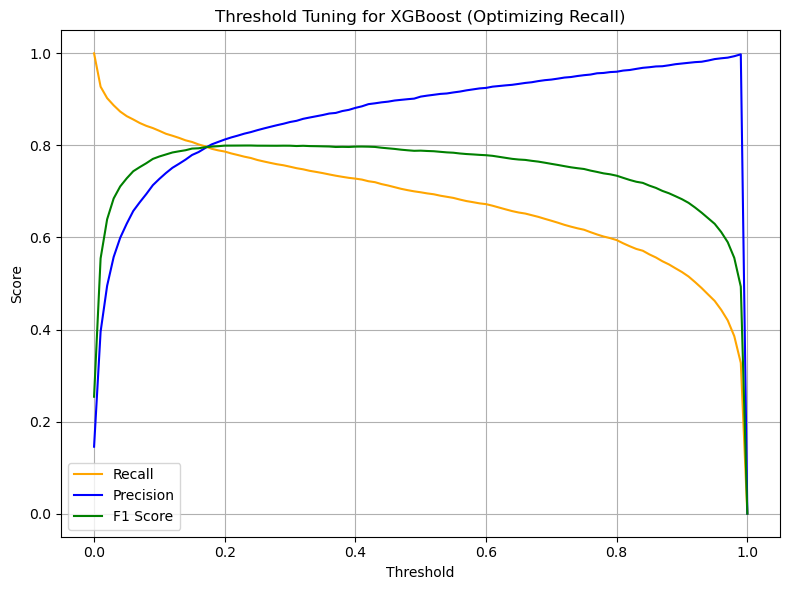

0.0

In [21]:
h.tune_threshold(xgb_model, metric='recall')

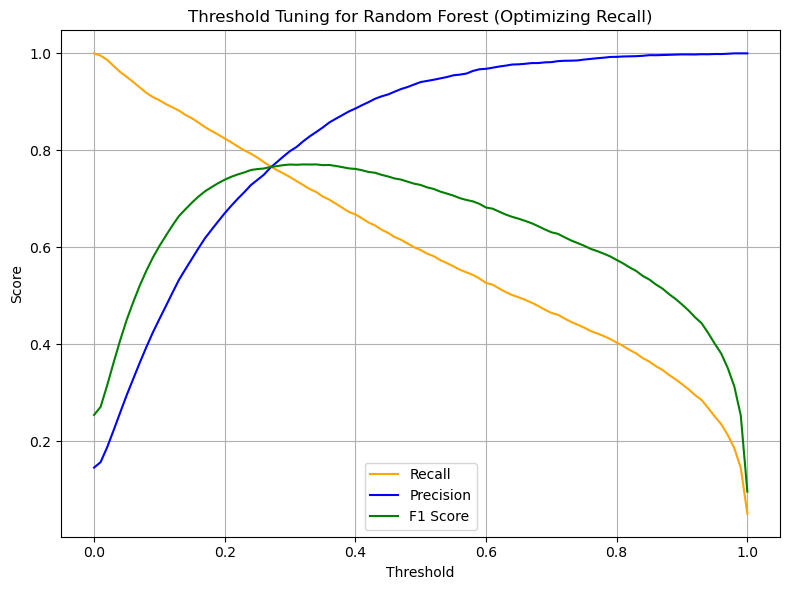

0.0

In [22]:
h.tune_threshold(rf_model, metric='recall')

In [31]:
manual_threshold = 0.2

# Get the true labels and predicted labels
y_true = xgb_model['y_test_true']
y_pred = (xgb_model['y_test_pred_proba'] >= manual_threshold).astype(int)  # Default threshold is 0.5

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[33126  1086]
 [ 1257  4571]]


In [32]:
manual_threshold = 0.2

# Get the true labels and predicted labels
y_true = rf_model['y_test_true']
y_pred = (rf_model['y_test_pred_proba'] >= manual_threshold).astype(int)  # Default threshold is 0.5

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[31863  2349]
 [ 1032  4796]]
